In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore, pearsonr
%matplotlib inline

"""
Takes about 2 mins to run.

CODE (not necessarily in order):
- Read in expression data and produce z-score
- Read in clinical info and clean up
- Read in sample level stats for tumor purity
- Combine clinical info with tumor purity and GADD45B expression
- Make clinical features numerical categories where relevant
- Make clinical features 'Tumor Purity' and 'Response to initial therapy' continuous using Gaussians
- Drop values with 5 or more NaNs
- Filter expression and z-score expression data to only include relevant patients

NOTES:
- Always merge on 'Sample ID', but drop column when using data
- Convention used throughout: patients (rows) x features/expression (columns)

RELEVANT DATA:
- reddy := expression data
- reddy_norm := normalised expression data
- all_genes := full list of genes in expression data 
- reddy_info := clinical info + tumor purity + gadd45b expression
- reddy_info_cols := variables in reddy_info
- patient_ids = sample/patient IDs for patients analysed in this project

"""

# transpose so columns: genes, rows: patients
reddy = np.transpose(pd.read_csv(
    'reddy_tmm_quantile_log2_normalised_gene_count_matrix_RSEM.csv',
                                 index_col=[0]))

# full list of genes in expression data
all_genes = pd.DataFrame(reddy.columns)

# remove null columns
reddy = reddy.loc[:, reddy.columns.notnull()]

# z-score on full dataset
reddy_norm = reddy.apply(lambda x: x if np.std(x) == 0 else zscore(x))

# index is sample IDs, so add this as a column for merging on normal and z-score
reddy['Sample ID'] = reddy.index
reddy['Sample ID'] = reddy['Sample ID'].apply(pd.to_numeric)

reddy_norm['Sample ID'] = reddy_norm.index
reddy_norm['Sample ID'] = reddy_norm['Sample ID'].apply(pd.to_numeric)


#####


# required subset of reddy clinical info
reddy_s1_clinical_info = pd.read_excel('full_reddy_s1.xlsx', 
                                       sheet_name='Clinical Information')

reddy_s1_clinical_info.columns = reddy_s1_clinical_info.iloc[2]
reddy_s1_clinical_info = reddy_s1_clinical_info.drop([0,1,2])

# don't need IPI groups since IPI more descriptive
reddy_s1_clinical_info = reddy_s1_clinical_info[['Sample  ID', 'IPI',
            'Response to initial therapy', 'Overall Survival years', 
            'Censored', 'ABC GCB (RNAseq)', 'ABC GCB ratio (RNAseq)', 
                            'age at diagnosis', 'Genomic Risk Model']]
reddy_s1_clinical_info = reddy_s1_clinical_info.rename(columns={
    "Sample  ID": "Sample ID", "Overall Survival years": "Overall survival years",
    "age at diagnosis": "AgeAtDiagnosis"})

# required subset of reddy sample level data
reddy_s1_sample_level = pd.read_excel('full_reddy_s1.xlsx', 
                                      sheet_name='Sample Level Stats')
reddy_s1_sample_level.columns = reddy_s1_sample_level.iloc[1]
reddy_s1_sample_level = reddy_s1_sample_level.drop([0,1])
reddy_s1_sample_level = reddy_s1_sample_level[['sample_ID', 
                                               'Tumor Purity']]
reddy_s1_sample_level = reddy_s1_sample_level.rename(columns={
    "sample_ID": 'Sample ID'})

# merge two subsets on Sample ID
reddy_info = pd.merge(reddy_s1_clinical_info, reddy_s1_sample_level, 
                      on='Sample ID', how='inner')


#####


# Genomic Risk Model - TODO: nan
reddy_info['Genomic Risk Model'] = reddy_info[
    'Genomic Risk Model'].replace({
        'Low risk': 1, 'Medium risk': 2, 'High risk': 3})

# need to convert IPI, Overall survival years, ABC GCB ratio, 
# Sample ID, AgeAtDiagnosis from object to int64/float64 for regression
reddy_info['IPI'] = reddy_info['IPI'].apply(pd.to_numeric)
reddy_info['Overall survival years'] = reddy_info[
    'Overall survival years'].apply(pd.to_numeric)
reddy_info['ABC GCB ratio (RNAseq)'] = reddy_info[
    'ABC GCB ratio (RNAseq)'].apply(pd.to_numeric)
reddy_info['AgeAtDiagnosis'] = reddy_info[
    'AgeAtDiagnosis'].apply(pd.to_numeric)
reddy_info['Sample ID'] = reddy_info[
    'Sample ID'].apply(pd.to_numeric)


# add gadd45b data by merging on sample ID
gadd45b_df = pd.DataFrame(reddy[['GADD45B', 'Sample ID']])
reddy_info = pd.merge(reddy_info, gadd45b_df, 
                      on='Sample ID', how='inner')

# percentage_missing = reddy_info.isnull().sum() * 100 / len(reddy_info)
# print(percentage_missing)

# drop values with 5 or more NaNs
reddy_info = reddy_info.dropna(thresh=6)


#####



# replace Tumor Purity ranges with Gaussian distr values
# randomness involved here
col = reddy_info['Tumor Purity'].values

for n, value in enumerate(col):
    if (value == '< 30%'):
        col[n] = 15
        continue
    if (value == '30 to 70%'):
        col[n] = 50
        continue
    if (value == '70% or more'):
        col[n] = 85
        continue

# convert to float64 for regression
reddy_info['Tumor Purity'] = reddy_info['Tumor Purity'].apply(pd.to_numeric)
reddy_info['Tumor Purity'] = reddy_info['Tumor Purity'] * 0.01

#####

# changing 'response to initial therapy' to continuous values
values = {'Response to initial therapy': 80}
reddy_info = reddy_info.fillna(value=values)

response_col = reddy_info['Response to initial therapy'].values

for n, value in enumerate(response_col):
    if (value == 'No response'):
        response_col[n] = min(5, max(0, np.random.normal(2.5,1.5)))
        continue
    if (value == 'Partial response'):
        # maybe change to be on the lower side - SEE PG 490 REDDY
        response_col[n] = min(95, max(5, np.random.normal(55, 15)))
        continue
    if (value == 'Complete response'):
        response_col[n] = min(100, max(95, np.random.normal(95, 1.5)))
        continue
    if pd.isna(np.isnan(response_col[n])):
        print(n)
        response_col[n] = min(100, max(0, np.random.normal(60, 15)))
        continue
# convert to float64 for regression
reddy_info['Response to initial therapy'] = reddy_info[
    'Response to initial therapy'].apply(pd.to_numeric)

# keep these columns for later
reddy_info_cols = pd.DataFrame(reddy_info.columns)

# these are the relevant patient IDs to use throughout
patient_ids = pd.DataFrame(reddy_info['Sample ID'])

# create final reddy/reddy_norm expression datasets with relevant patients (n=773)
reddy = pd.merge(reddy, patient_ids, 
                      on='Sample ID', how='inner')

reddy_norm = pd.merge(reddy_norm, patient_ids, 
                      on='Sample ID', how='inner')


In [2]:
"""
CODE (not necessarily in order):
- Impute GRM then IPI then AAD then OSY

NOTES:
- Order of imputation may produce different results

RELEVANT DATA:
- N/A

"""

# MICE: GRM
import statsmodels.imputation.mice as mice
import statsmodels.regression.linear_model as lm

reddy_info = reddy_info.rename(columns={
    "Response to initial therapy": 'ResponseToInitialTherapy'})
reddy_info = reddy_info.rename(columns={
    "ABC GCB ratio (RNAseq)": 'Ratio'})
reddy_info = reddy_info.rename(columns={
    "Genomic Risk Model": 'GRM'})
reddy_info = reddy_info.rename(columns={
    "Overall survival years": 'OverallSurvivalYears'})
reddy_info = reddy_info.rename(columns={
    "Tumor Purity": "TumorPurity"})
reddy_info = reddy_info.rename(columns={
    "ABC GCB (RNAseq)": 'ABCGCB'})

# as specified in the MICE paper, "MICE: what is it and how does it work?'", 
# we use all possible variables (i.e. all continuous) variables in the regression
grm = reddy_info[['GRM', 'Ratio', 'GADD45B', 'AgeAtDiagnosis',
                  'ResponseToInitialTherapy', 'IPI', 'OverallSurvivalYears', 'TumorPurity']]

print("How many null values in GRM? ", reddy_info['GRM'].isnull().sum())

imp_grm = mice.MICEData(grm)
# formula: column to impute ~ columns you impute off of
fml_grm = "GRM ~ Ratio + GADD45B + ResponseToInitialTherapy + IPI + OverallSurvivalYears + AgeAtDiagnosis"
mice_grm = mice.MICE(fml_grm, lm.OLS, imp_grm)

results = mice_grm.fit(10,10) # fit(#cycles to skip, #datasets to impute)
#print(results.summary())

# replace original column with MICE'd column
reddy_info['GRM'] = mice_grm.data.data['GRM'].values

# check to make sure there are no more null values
print("How many null values in GRM now? ", reddy_info['GRM'].isnull().sum())

#####

# MICE: IPI

ipi = reddy_info[['GRM', 'Ratio', 'GADD45B', 'AgeAtDiagnosis',
                  'ResponseToInitialTherapy', 'IPI', 'OverallSurvivalYears']]

print("How many null values in IPI? ", reddy_info['IPI'].isnull().sum())

imp_ipi = mice.MICEData(ipi)
# formula: column to impute ~ columns you impute off of
fml_ipi = "IPI ~ GRM + Ratio + GADD45B + ResponseToInitialTherapy + OverallSurvivalYears + AgeAtDiagnosis"
mice_ipi = mice.MICE(fml_ipi, lm.OLS, imp_ipi)

results = mice_ipi.fit(10,10) # fit(#cycles to skip, #datasets to impute)
#print(results.summary())

# replace original column with MICE'd column
reddy_info['IPI'] = mice_ipi.data.data['IPI'].values

print("How many null values in IPI now? ", reddy_info['GRM'].isnull().sum())


#####

# MICE: AgeAtDiagnosis

aad = reddy_info[['GRM', 'Ratio', 'GADD45B', 'AgeAtDiagnosis',
                  'ResponseToInitialTherapy', 'IPI', 'OverallSurvivalYears']]

print("How many null values in AgeAtDiagnosis? ", reddy_info['IPI'].isnull().sum())

imp_add = mice.MICEData(aad)
# formula: column to impute ~ columns you impute off of
fml_aad = "AgeAtDiagnosis ~ IPI + GRM + Ratio + GADD45B + ResponseToInitialTherapy + OverallSurvivalYears"
mice_aad = mice.MICE(fml_aad, lm.OLS, imp_add)

results = mice_aad.fit(10,10) # fit(#cycles to skip, #datasets to impute)
#print(results.summary())

# replace original column with MICE'd column
reddy_info['AgeAtDiagnosis'] = mice_aad.data.data['AgeAtDiagnosis'].values

print("How many null values in AgeAtDiagnosis now? ", reddy_info['AgeAtDiagnosis'].isnull().sum())

#####

# MICE: OverallSurvivalYears

osy = reddy_info[['GRM', 'Ratio', 'GADD45B', 'AgeAtDiagnosis',
                  'ResponseToInitialTherapy', 'IPI', 'OverallSurvivalYears']]

print("How many null values in overall survival years? ",
      reddy_info['OverallSurvivalYears'].isnull().sum())

imp_osy = mice.MICEData(osy)
# formula: column to impute ~ columns you impute off of
fml_osy = "OverallSurvivalYears ~ GRM + Ratio + GADD45B + IPI+ ResponseToInitialTherapy + AgeAtDiagnosis"
mice_osy = mice.MICE(fml_osy, lm.OLS, imp_osy)

results = mice_osy.fit(10,10) # fit(#cycles to skip, #datasets to impute)
#print(results.summary())

# check to make sure there are no more null values
print("How many null values in overall survival years now? ",
      reddy_info['GRM'].isnull().sum())

# replace original column with MICE'd column
reddy_info['OverallSurvivalYears'] = mice_osy.data.data['OverallSurvivalYears'].values

print("How many null values in 'Censored'? ", reddy_info['Censored'].isnull().sum())

# since we now have complete data for 'OverallSurvivalYears', we can set the null
# censored values to being censored since we can assume the patients could not be followed up

# 0 means censored, 1 means uncensored
values = {'Censored': 0}
reddy_info = reddy_info.fillna(value=values)
print("How many null values in 'Censored' now? ", reddy_info['Censored'].isnull().sum())

print("We now have " + str(len(reddy_info)) + " patients with complete data")

How many null values in GRM?  22
How many null values in GRM now?  0
How many null values in IPI?  152
How many null values in IPI now?  0
How many null values in AgeAtDiagnosis?  0
How many null values in AgeAtDiagnosis now?  0
How many null values in overall survival years?  19
How many null values in overall survival years now?  0
How many null values in 'Censored'?  7
How many null values in 'Censored' now?  0
We now have 775 patients with complete data


In [3]:
# for variance filtering
from sklearn.feature_selection import VarianceThreshold

# for Laplacian score filtering
from skfeature.utility import construct_W
from skfeature.function.similarity_based import lap_score

# for nimfa NMF
import nimfa
from sklearn import preprocessing

# for heatmap and hierarchical clustering
import matplotlib.gridspec as gridspec
import scipy.cluster.hierarchy as sch
from scipy.spatial import distance
from scipy.cluster import hierarchy

# for general graphing
import seaborn as sns


# get COO and GRM labels for clustering

labels_reddy = pd.merge(reddy_info[['Sample ID', 'ABCGCB', 'GRM', 'IPI']], reddy, on='Sample ID', how='inner')
labels_reddy.rename(columns={'Sample ID': 'PatientID', 'ABCGCB': 'COOClass'}, inplace=True)
# set_index automatically removes from normal columns
labels_reddy.set_index('PatientID', inplace=True)

# create COO and GRM list for future clustermap annotation
coo_list = labels_reddy['COOClass']
grm_list = labels_reddy['GRM']
ipi_list = labels_reddy['IPI']
# remove for clustering
labels_reddy.drop(columns=['COOClass', 'GRM', 'IPI'], inplace=True)

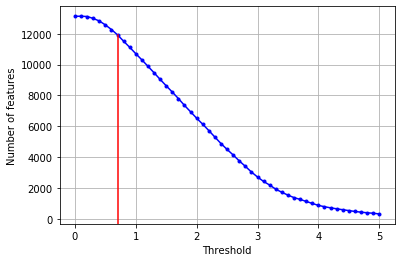

In [4]:
"""
CODE (not necessarily in order):
- Feature selelection method 1: variance thresholding.
- See the amount of features preserved for different thresholds.

NOTES:
- Try thresholds from 0 to 5 with step size 0.1.

RELEVANT DATA:
- vt_reddy :- variance thresholded reddy

"""

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# create thresholds from 0 to 5 with step size 0.1
thresholds = np.linspace(0, 5, 51)
num_features = []

# for each threshold, figure out number of features present
for threshold in thresholds:
    vt_reddy = variance_threshold_selector(labels_reddy, threshold)
    num_features.append(len(vt_reddy.T))
    

# plot graph of no. features against threshold
plt.plot(thresholds, num_features, '.b-')
plt.xlabel("Threshold")
plt.ylabel("Number of features")
plt.grid(True)
plt.axvline(x=0.70, ymax=0.87, color='r')

From this graph, we can see that the number of features starts decreasing linearly at a threshold of around 0.70 as indicated by the red line. Therefore, we make this our threshold to get rid of highly non-variable features (which are essentially treated as noise) which we can then perform Laplacian score filtering on.

In [5]:
# apply suitable threshold to real data

# t=0.7 initially
vt_reddy = variance_threshold_selector(labels_reddy, 3)

# drop GADD45B if still present as should not be used for clustering - only for eval
if 'GADD45B' in vt_reddy.columns:
    vt_reddy = vt_reddy.drop(columns=['GADD45B'])

post_vt_features = len(vt_reddy.T)
print("Reddy data now has " + str(post_vt_features) + " genetic features remaining.")

Reddy data now has 2708 genetic features remaining.


Text(0, 0.5, 'Laplacian Score')

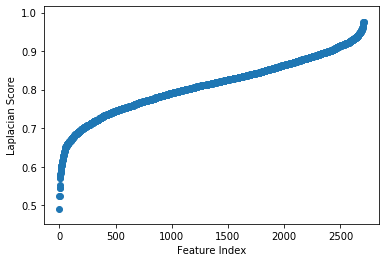

In [6]:
"""
CODE (not necessarily in order):
- Feature selelection method 2: Laplacian score filtering.

NOTES:
- Using skfeature library.
- Smaller Laplacian score is better.

RELEVANT DATA:
- vt_reddy :- variance-thresholded reddy data

"""

tr_numpy = vt_reddy.to_numpy()

# construct affinity matrix
# AV: kwargs_W = {"metric":"euclidean","neighbor_mode":"knn","weight_mode":"heat_kernel","k":20,'t':500}
kwargs_W = {"metric":"cosine","neighbor_mode":"knn","weight_mode":"cosine","k":40,'t':500} # EA
W = construct_W.construct_W(tr_numpy, **kwargs_W)

# compute lap score of each remaining features
score = lap_score.lap_score(tr_numpy, W=W)

# plot graph of feeatures in ascending Laplacian score
sorted_scores = np.sort(score)
xs = [i for i in range(len(sorted_scores))]
plt.scatter(xs, sorted_scores)
plt.xlabel("Feature Index")
plt.ylabel("Laplacian Score")
# plt.axvline(x=1500, ymax=(sorted_scores[1500]-0.32)/0.6, color='r')

Note: in the Laplacian score we are looking for the smallest features. In a similar way to the variance thresholding graph, we find the point where the graph starts increasing linearly and use the number of features up till there. We find the number of relevant features to be 1500.

In [164]:
# select our best features

# rank features
idx = lap_score.feature_ranking(score)

# want number of features to be those in top band of lap_scores
n_features = 100 #1500
filtered_reddy = vt_reddy.iloc[:,idx[0:n_features]].copy()
# trying with worst 100 to see if makes difference
#filtered_reddy = vt_reddy.iloc[:,idx[-n_features:]].copy()

print("The Reddy data now has " + str(n_features) + " features after Laplacian score filtering.")

The Reddy data now has 100 features after Laplacian score filtering.


In [8]:
import numpy as np
import pandas as pd

In [165]:
"""
CODE (not necessarily in order):
- Try different ranks for each algorithm and find best using following metrics.

NOTES:
- Using Nimfa library.
- Iterating through ranks 4-10.
- Clustering patients: reddy_to_cluster.T
- Clustering genes: reddy_to_cluster

RELEVANT DATA:
- filtered_reddy :- reddy gene expression data after feature selection
- reddy_subset :- (subset of) filtered_reddy. This is a dataframe.
- reddy_to_cluster :- normalised numpy version of reddy_subset. Used in clustering algorithms.
- summary :- dictionary of results for each rank.

"""

# .iloc[patients, genes]
#reddy_subset = filtered_reddy.iloc[0:200,0:100].copy()
reddy_subset = filtered_reddy.iloc[:,:].copy()
reddy_to_cluster = reddy_subset.to_numpy()
reddy_to_cluster = preprocessing.Normalizer().fit_transform(reddy_to_cluster)

# number of patients and genes for printing later on
num_pat = reddy_to_cluster.shape[0]
num_genes = reddy_to_cluster.shape[1]

# .T if patients
reddy_to_cluster = reddy_to_cluster.T

# set algorithm label for printing
nmf_label = "ICM"


In [176]:
rank = 10

alpha_bnmf = np.random.randn(reddy_to_cluster.shape[0], rank) # basis W prior
beta_bnmf = np.random.randn(rank, reddy_to_cluster.shape[1]) # mixture H prior
theta_bnmf = 10
k_bnmf = 0
sigma_bnmf = 1

In [177]:
icm = nimfa.Icm(reddy_to_cluster, rank=rank, seed="random_vcol", track_factor=True, n_run=20, 
                alpha=alpha_bnmf, beta=beta_bnmf, theta=theta_bnmf, k=k_bnmf, sigma=sigma_bnmf)
icm_fit = icm()

In [ ]:
#####

In [178]:
cons = icm_fit.fit.consensus()

# create distance matrix from clustering consensus matrix
d = 1 - cons
d = pd.DataFrame(d)
# add annotation (cols for patients, rows for genes)
cols = reddy_subset.index
d.set_index(cols, inplace=True)
d.columns = cols

# calculate squareform so element-wise rather than row-wise in linkage
dist = distance.squareform(d)

# create linkage matrix for clustermap
linkage = sch.linkage(dist, method='average') # AV
# linkage = sch.linkage(distance.squareform(d), method='ward', metric='cosine') # EA

In [179]:
"""
CODE (not necessarily in order):
- Regaining cluster information: creating our patient subgroups.

NOTES:
- Using fcluster with 'maxclust': set middle param to number of clusters i.e. rank.

RELEVANT DATA:
- subgroups :- {subgroup_number: list of patients in that subgroup}

"""

# regain the clusters assignments of each datapoint
fl = sch.fcluster(linkage, rank, criterion='maxclust')

# zip reordered indices with cluster assignment
# fcluster returns cluster assignments in patients' original ordering so zip(range(n+1), fl)
index_with_cluster = list(zip(range(num_pat+1), fl)) # EA: range(n), AV: range(n+1), otherwise leave last patient off

# replace indices with corresponding patient_id
# add patient_id and corresponding cluster_assignment to dictionary
patient_to_cluster = {}
for (index, cluster_assignment) in index_with_cluster:
    patient_id = cols[index]
    patient_to_cluster[patient_id] = cluster_assignment

# add patients to their corresponding subgroups for evaluation
from collections import defaultdict
subgroups = defaultdict(list)
for (index, cluster_assignment) in index_with_cluster:
    subgroups[cluster_assignment].append(cols[index])

In [180]:
# 21 distinct colours for colouring subgroups

import random

distinct_cols = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), 
                 (70, 240, 240), (240, 50, 230), (210, 245, 60), (250, 190, 212), (0, 128, 128), 
                 (220, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0), (170, 255, 195), 
                 (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (0, 0, 0), (0, 0, 0),(0, 0, 0),(0, 0, 0),(0, 0, 0),(0, 0, 0),(0, 0, 0),(0, 0, 0),(0, 0, 0),(0, 0, 0),(0, 0, 0)]

distinct_cols = [(r/255, g/255, b/255) for (r,g,b) in distinct_cols]

def generate_colmap_for_subgroups(rank):  

    # generate random list of numbers
    num_cols = len(distinct_cols)
    array = list(range(num_cols))
    random.shuffle(array)

    colmap = {}
    # use subgroups.keys() so can reuse subgroup colours
    for sg_id in subgroups.keys():
        colmap[sg_id] = distinct_cols[sg_id]
        
    return colmap 

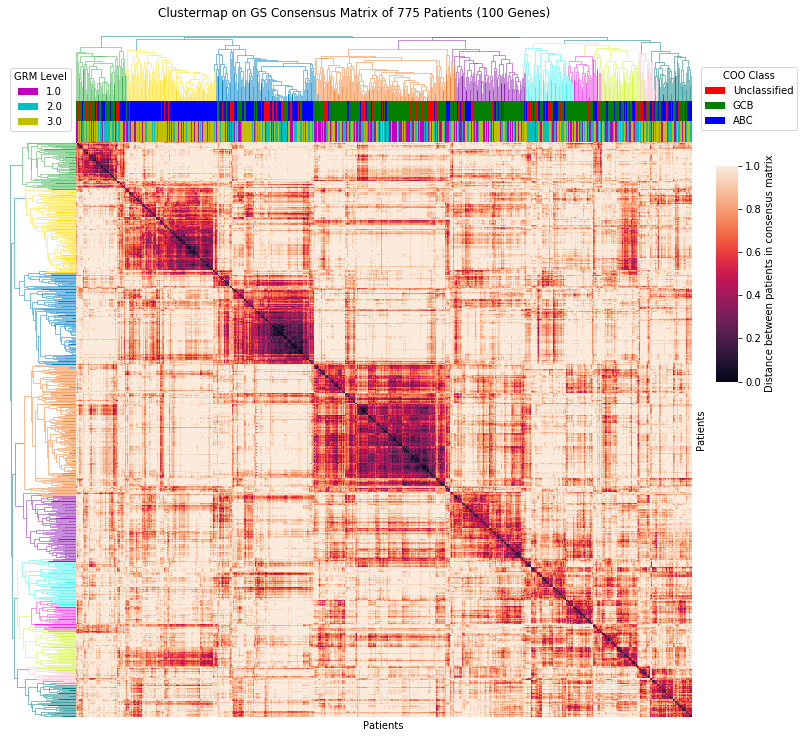

In [181]:
### CLUSTERMAP VISUALISATION

# add COO classification to clustermap
coo_bar = dict(zip(coo_list.unique(), "rgb"))
coo_cols = coo_list.map(coo_bar)
coo_cols.rename("COO Class", inplace=True)

# add GRM classification to clustermap
grm_bar = dict(zip(grm_list.unique(), "cmy"))
grm_cols = grm_list.map(grm_bar)
grm_cols.rename("GRM Level", inplace=True)
# sort so smallest value first
grm_bar = dict(sorted(grm_bar.items(), key=lambda x:x[0]))

# generate colours for n subgroups
colmap = generate_colmap_for_subgroups(rank)

# used to get cluster assignments in order of how they appear on dendrogram for colouring
index_to_cluster = dict(index_with_cluster)
reordered_ind = sch.leaves_list(linkage)

# plot clustermap
g = sns.clustermap(d, metric='euclidean', row_linkage=linkage, col_linkage=linkage,
                   col_colors=[coo_cols, grm_cols], yticklabels=False, xticklabels=False,
                   dendrogram_ratio=(0.1, 0.1), cbar_pos=(1, .5, .03, .3),
                   cbar_kws={'label': 'Distance between patients in consensus matrix'},
                   tree_kws={'colors':[colmap[index_to_cluster[ca]] for ca in reordered_ind]})

# don't show row dendrogram 
#g.ax_row_dendrogram.set_visible(False)

# set title and labels
title = "Clustermap on GS Consensus Matrix of " + str(num_pat) + " Patients (" + str(num_genes) + " Genes) \n\n"

g.fig.suptitle(title, y=1.02)
g.ax_heatmap.set_xlabel("Patients")
g.ax_heatmap.set_ylabel("Patients")

# create COO legend
for (label, colour) in coo_bar.items():
    g.ax_col_dendrogram.bar(5, 0, color=colour, label="{}".format(label))

g.ax_col_dendrogram.legend(title='COO Class', loc="lower right", ncol=1, bbox_to_anchor=(1.18, -0.5))

for (label, colour) in grm_bar.items():
    g.ax_row_dendrogram.bar(5, 0, color=colour, label="{}".format(label))

g.ax_row_dendrogram.legend(title='GRM Level', loc="lower right", ncol=1, bbox_to_anchor=(1, 1.01))

# plt.savefig('bd-cmap.png', bbox_inches = 'tight') 

In [182]:
# to set different purities for data
purity = 0
final_reddy = reddy_info[reddy_info['TumorPurity'] > purity].copy()

# only use the patients you clustered on
reddy_subset['Sample ID'] = reddy_subset.index
final_reddy = pd.merge(final_reddy, reddy_subset['Sample ID'], on='Sample ID')

# intialise a subgroup assignment column to 0
final_reddy['Subgroup'] = 0

# add assigned subgroup for each patient
for sg_id in subgroups.keys():
    final_reddy.loc[final_reddy['Sample ID'].isin(subgroups[sg_id]), 'Subgroup'] = sg_id

In [183]:
# print subgroup id with number of patients in subgroup (in order)
for i in range(len(subgroups.keys())):
    print(i+1, ": ", len(final_reddy[final_reddy['Subgroup']==i+1]))

1 :  62
2 :  111
3 :  127
4 :  172
5 :  89
6 :  57
7 :  33
8 :  56
9 :  16
10 :  52


In [184]:
for i in range(len(subgroups.keys())):
    sg = final_reddy[final_reddy['Subgroup'] == i+1]['ABCGCB']
    print("These are the proportions of COO classifications present in Subgroup " + 
          str(i+1) + " (n=" + str(len(sg)) + "):")
    print(sg.value_counts(normalize=True) * 100)
    print()

These are the proportions of COO classifications present in Subgroup 1 (n=62):
GCB             41.935484
ABC             33.870968
Unclassified    24.193548
Name: ABCGCB, dtype: float64

These are the proportions of COO classifications present in Subgroup 2 (n=111):
ABC             92.792793
Unclassified     6.306306
GCB              0.900901
Name: ABCGCB, dtype: float64

These are the proportions of COO classifications present in Subgroup 3 (n=127):
ABC             59.842520
GCB             20.472441
Unclassified    19.685039
Name: ABCGCB, dtype: float64

These are the proportions of COO classifications present in Subgroup 4 (n=172):
GCB             66.860465
Unclassified    18.604651
ABC             14.534884
Name: ABCGCB, dtype: float64

These are the proportions of COO classifications present in Subgroup 5 (n=89):
GCB             74.157303
ABC             16.853933
Unclassified     8.988764
Name: ABCGCB, dtype: float64

These are the proportions of COO classifications present in Su

In [185]:
for i in range(len(subgroups.keys())):
    sg = final_reddy[final_reddy['Subgroup'] == i+1]['GRM']
    print("These are the proportions of GRM classifications present in Subgroup " + 
          str(i+1) + " (n=" + str(len(sg)) + "):")
    print(sg.value_counts(normalize=True) * 100)
    print()

These are the proportions of GRM classifications present in Subgroup 1 (n=62):
2.0    41.935484
3.0    37.096774
1.0    20.967742
Name: GRM, dtype: float64

These are the proportions of GRM classifications present in Subgroup 2 (n=111):
3.0    64.864865
1.0    19.819820
2.0    15.315315
Name: GRM, dtype: float64

These are the proportions of GRM classifications present in Subgroup 3 (n=127):
3.0    44.094488
2.0    37.795276
1.0    18.110236
Name: GRM, dtype: float64

These are the proportions of GRM classifications present in Subgroup 4 (n=172):
1.0    45.930233
2.0    30.813953
3.0    23.255814
Name: GRM, dtype: float64

These are the proportions of GRM classifications present in Subgroup 5 (n=89):
3.0    47.191011
1.0    34.831461
2.0    17.977528
Name: GRM, dtype: float64

These are the proportions of GRM classifications present in Subgroup 6 (n=57):
2.0    52.631579
3.0    28.070175
1.0    19.298246
Name: GRM, dtype: float64

These are the proportions of GRM classifications presen

In [ ]:
######
######
######

In [ ]:
cons = np.zeros((num_pat, num_pat))
runs = 10
for i in range(runs):
    icm = nimfa.Icm(reddy_to_cluster, seed="random_vcol")
    icm_fit = icm()
    cons += icm_fit.fit.consensus()
cons /= runs

In [131]:
(icm_fit.fit.consensus() == icm_fit.summary()['connectivity']).all()

False

In [132]:
cons = icm_fit.fit.consensus()

# create distance matrix from clustering consensus matrix
d = 1 - cons
d = pd.DataFrame(d)
# add annotation (cols for patients, rows for genes)
cols = reddy_subset.index
d.set_index(cols, inplace=True)
d.columns = cols

# calculate squareform so element-wise rather than row-wise in linkage
dist = distance.squareform(d)

# create linkage matrix for clustermap
linkage = sch.linkage(dist, method='average') # AV
# linkage = sch.linkage(distance.squareform(d), method='ward', metric='cosine') # EA

In [55]:
# set rank candidates
rank_cands = range(4, 21, 2)

# BD
#bd = nimfa.Bd(reddy_to_cluster.T, seed="random_c", theta=0.5, k=0.5, sigma=1.)
#summary = bd.estimate_rank(rank_range=rank_cands, n_run=10, what='all')

alpha_bnmf = np.random.randn(reddy_to_cluster.shape[0], 10) # basis W prior
beta_bnmf = np.random.randn(10, reddy_to_cluster.shape[1]) # mixture H prior
theta_bnmf = 0
k_bnmf = 0
sigma_bnmf = 1

#=====================================
# Iterate Icm decomposition & average
# output = cons
# parameters:
# theta = default=0
# k = = default 0
# sigma = noise variance = default =1
# Loads of parameters to investigate. supervised addition?
#=====================================

# ICM
icm = nimfa.Icm(reddy_to_cluster, seed="random_vcol", alpha=alpha_bnmf, beta=beta_bnmf,
                theta=theta_bnmf, k=k_bnmf, sigma=sigma_bnmf)
summary = icm.estimate_rank(rank_range=rank_cands, n_run=3, what='all')

# LSNMF
#lsnmf = nimfa.Lsnmf(reddy_to_cluster.T, seed="random_vcol", max_iter=100, sub_iter=10,
#                    inner_sub_iter=10, beta=0.5)
#summary = lsnmf.estimate_rank(rank_range=rank_cands, n_run=40, what='all')

# PSMF
#psmf = nimfa.Psmf(reddy_to_cluster.T, seed=None, max_iter=12, prior=np.random.rand(10))
#summary = psmf.estimate_rank(rank_range=rank_cands, n_run=2, what='all')

# PMF
#pmf = nimfa.Pmf(reddy_to_cluster.T, seed="random_vcol", max_iter=80, rel_error=1e-5)
#summary = pmf.estimate_rank(rank_range=rank_cands, n_run=30, what='all')

# summary[4].keys()

In [ ]:
# plotting cophenetic correlation and dispersion
coph = [summary[rank]['cophenetic'] for rank in rank_cands]
disp = [summary[rank]['dispersion'] for rank in rank_cands]

plt.plot(rank_cands, coph, 'o-', label='Cophenetic correlation',linewidth=2)
plt.plot(rank_cands, disp,'o-', label='Dispersion', linewidth=2)

plt.legend(loc='center',  ncol=3, numpoints=1);
cd_title = nmf_label + ": Cluster metric scores as rank is varied"
plt.title(cd_title)
plt.xlabel("Rank")
plt.ylabel("Metric Scores")

Text(0.5, 0, 'Rank')

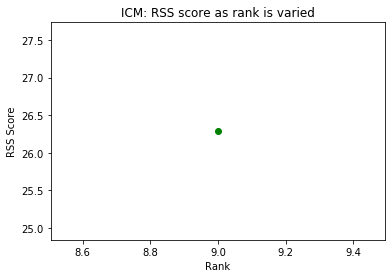

In [58]:
# plotting residual sum of squares

rss = [summary[rank]['rss'] for rank in rank_cands]

plt.plot(rank_cands, rss, 'og-', label='RSS', linewidth=2)
rss_title = nmf_label + ": RSS score as rank is varied"
plt.title(rss_title)
plt.ylabel("RSS Score")
plt.xlabel("Rank")

In [59]:
# creating combined metric
# might need to change/remove max rank value

def combined_metric(cci, d, rss, rank):
    return (0.5*cci + 0.5*d - 0.1*rss - 0.1*(rank))

# scale RSS for CM
max_rss = max(rss)
new_rss = [i/max_rss for i in rss]

# scale rank for CM
rank = rank_cands
max_rank = 20 # 10 originally
new_rank =[i/max_rank for i in rank]

# combine metrics in list for each rank
rank_metrics = list(zip(rank, coph, disp, new_rss, new_rank))

# create CM for each lrank
final_scores = []
for rank in rank_metrics:
    cm = combined_metric(rank[1], rank[2], rank[3], rank[4])
    final_scores.append((rank[0], cm))

Text(0.5, 0, 'Rank')

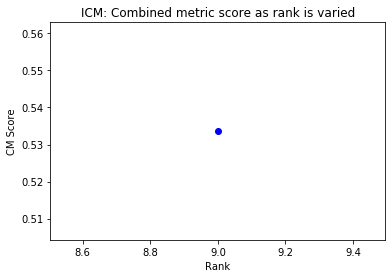

In [60]:
# plot combined metric score
plt.plot(*zip(*final_scores), 'ob-' ,linewidth=2)
cm_title = nmf_label + ": Combined metric score as rank is varied"
plt.title(cm_title)
plt.ylabel("CM Score")
plt.xlabel("Rank")

In [94]:
# pick best rank based on CM score
#rank = max(final_scores, key=lambda x: x[1])[0]

# create distance matrix from clustering consensus matrix
#d = 1 - summary[rank]['consensus']
d = 1 - icm_fit.fit.consensus()
d = pd.DataFrame(d)
# add annotation (cols for patients, rows for genes)
cols = reddy_subset.index
d.set_index(cols, inplace=True)
d.columns = cols

# calculate squareform so element-wise rather than row-wise in linkage
dist = distance.squareform(d)

# create linkage matrix for clustermap
linkage = sch.linkage(dist, method='average') # AV
# linkage = sch.linkage(distance.squareform(d), method='ward', metric='cosine') # EA

In [119]:
"""
CODE (not necessarily in order):
- Regaining cluster information: creating our patient subgroups.

NOTES:
- Using fcluster with 'maxclust': set middle param to number of clusters i.e. rank.

RELEVANT DATA:
- subgroups :- {subgroup_number: list of patients in that subgroup}

"""

# regain the clusters assignments of each datapoint
fl = sch.fcluster(linkage, rank, criterion='maxclust')

# zip reordered indices with cluster assignment
# fcluster returns cluster assignments in patients' original ordering so zip(range(n+1), fl)
index_with_cluster = list(zip(range(num_pat+1), fl)) # EA: range(n), AV: range(n+1), otherwise leave last patient off

# replace indices with corresponding patient_id
# add patient_id and corresponding cluster_assignment to dictionary
patient_to_cluster = {}
for (index, cluster_assignment) in index_with_cluster:
    patient_id = cols[index]
    patient_to_cluster[patient_id] = cluster_assignment

# add patients to their corresponding subgroups for evaluation
from collections import defaultdict
subgroups = defaultdict(list)
for (index, cluster_assignment) in index_with_cluster:
    subgroups[cluster_assignment].append(cols[index])

In [120]:
# 21 distinct colours for colouring subgroups

import random

distinct_cols = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), 
                 (70, 240, 240), (240, 50, 230), (210, 245, 60), (250, 190, 212), (0, 128, 128), 
                 (220, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0), (170, 255, 195), 
                 (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (0, 0, 0), (0, 0, 0),(0, 0, 0),(0, 0, 0),(0, 0, 0),(0, 0, 0),(0, 0, 0),(0, 0, 0),(0, 0, 0),(0, 0, 0),(0, 0, 0)]

distinct_cols = [(r/255, g/255, b/255) for (r,g,b) in distinct_cols]

def generate_colmap_for_subgroups(rank):  

    # generate random list of numbers
    num_cols = len(distinct_cols)
    array = list(range(num_cols))
    random.shuffle(array)

    colmap = {}
    # use subgroups.keys() so can reuse subgroup colours
    for sg_id in subgroups.keys():
        colmap[sg_id] = distinct_cols[sg_id]
        
    return colmap 

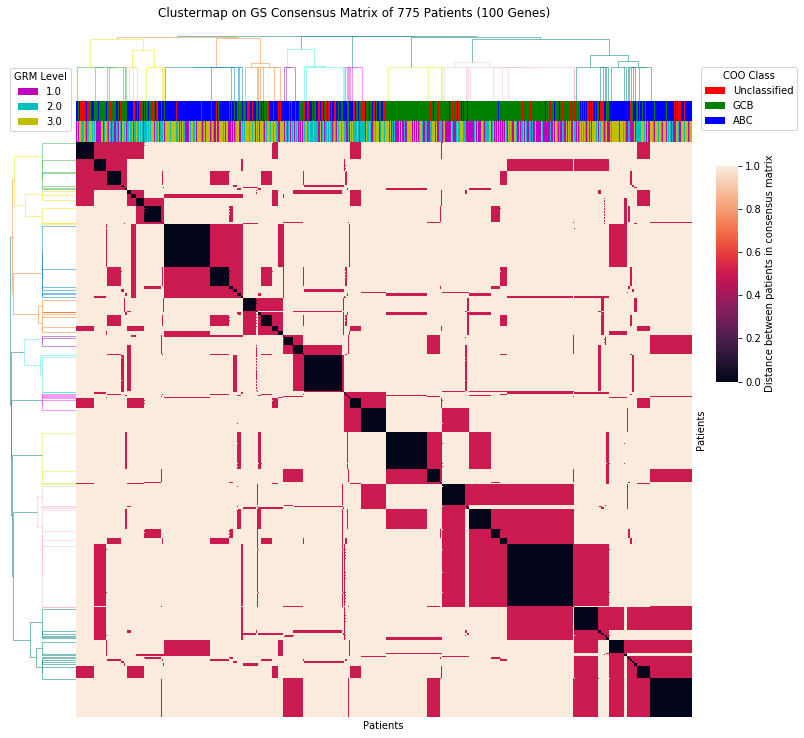

In [121]:
### CLUSTERMAP VISUALISATION

# add COO classification to clustermap
coo_bar = dict(zip(coo_list.unique(), "rgb"))
coo_cols = coo_list.map(coo_bar)
coo_cols.rename("COO Class", inplace=True)

# add GRM classification to clustermap
grm_bar = dict(zip(grm_list.unique(), "cmy"))
grm_cols = grm_list.map(grm_bar)
grm_cols.rename("GRM Level", inplace=True)
# sort so smallest value first
grm_bar = dict(sorted(grm_bar.items(), key=lambda x:x[0]))

# generate colours for n subgroups
colmap = generate_colmap_for_subgroups(rank)

# used to get cluster assignments in order of how they appear on dendrogram for colouring
index_to_cluster = dict(index_with_cluster)
reordered_ind = sch.leaves_list(linkage)

# plot clustermap
g = sns.clustermap(d, metric='euclidean', row_linkage=linkage, col_linkage=linkage,
                   col_colors=[coo_cols, grm_cols], yticklabels=False, xticklabels=False,
                   dendrogram_ratio=(0.1, 0.1), cbar_pos=(1, .5, .03, .3),
                   cbar_kws={'label': 'Distance between patients in consensus matrix'},
                   tree_kws={'colors':[colmap[index_to_cluster[ca]] for ca in reordered_ind]})

# don't show row dendrogram 
#g.ax_row_dendrogram.set_visible(False)

# set title and labels
title = "Clustermap on GS Consensus Matrix of " + str(num_pat) + " Patients (" + str(num_genes) + " Genes) \n\n"

g.fig.suptitle(title, y=1.02)
g.ax_heatmap.set_xlabel("Patients")
g.ax_heatmap.set_ylabel("Patients")

# create COO legend
for (label, colour) in coo_bar.items():
    g.ax_col_dendrogram.bar(5, 0, color=colour, label="{}".format(label))

g.ax_col_dendrogram.legend(title='COO Class', loc="lower right", ncol=1, bbox_to_anchor=(1.18, -0.5))

for (label, colour) in grm_bar.items():
    g.ax_row_dendrogram.bar(5, 0, color=colour, label="{}".format(label))

g.ax_row_dendrogram.legend(title='GRM Level', loc="lower right", ncol=1, bbox_to_anchor=(1, 1.01))

# plt.savefig('bd-cmap.png', bbox_inches = 'tight') 

In [114]:
### EVALUATION

In [35]:
# for i in sch.leaves_list(linkage): print(fl[i])
(g.dendrogram_col.reordered_ind==sch.leaves_list(linkage)).all()

True

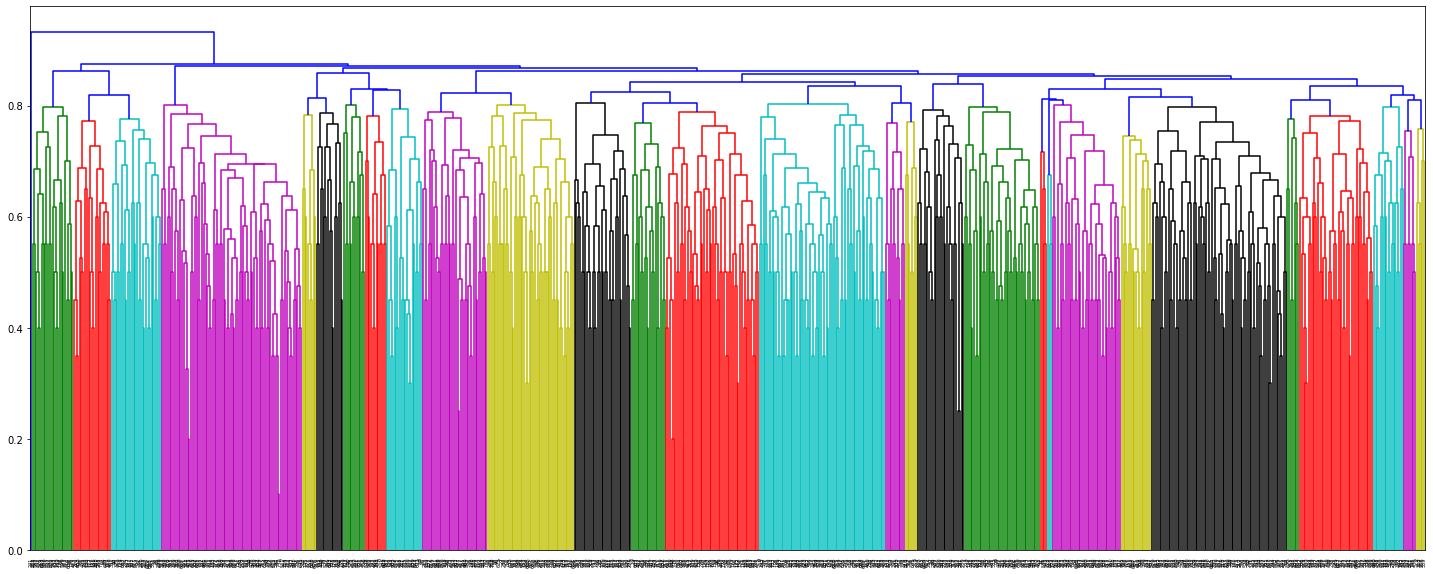

In [22]:
# linkage[_] = [c1, c2, d, n]
# c1 and c2 are two clusters
# d is the distance between them
# n is the number of singletons across both

# linkage[-(k-1)] is the k-th biggest cluster
# therefore linkage[-(k-1), d] returns the distance threshold
# required for k clusters
ct = linkage[-(rank-1), 2]

fig = plt.figure(figsize=(25, 10))
dn = sch.dendrogram(linkage,show_leaf_counts=False,
                    color_threshold=ct)
sch.set_link_color_palette(None)
plt.show()

In [122]:
# to set different purities for data
purity = 0
final_reddy = reddy_info[reddy_info['TumorPurity'] > purity].copy()

# only use the patients you clustered on
reddy_subset['Sample ID'] = reddy_subset.index
final_reddy = pd.merge(final_reddy, reddy_subset['Sample ID'], on='Sample ID')

# intialise a subgroup assignment column to 0
final_reddy['Subgroup'] = 0

# add assigned subgroup for each patient
for sg_id in subgroups.keys():
    final_reddy.loc[final_reddy['Sample ID'].isin(subgroups[sg_id]), 'Subgroup'] = sg_id

In [123]:
# print subgroup id with number of patients in subgroup (in order)
for i in range(len(subgroups.keys())):
    print(i+1, ": ", len(final_reddy[final_reddy['Subgroup']==i+1]))

1 :  65
2 :  46
3 :  100
4 :  50
5 :  25
6 :  52
7 :  53
8 :  71
9 :  166
10 :  147


In [124]:
for i in range(len(subgroups.keys())):
    sg = final_reddy[final_reddy['Subgroup'] == i+1]['ABCGCB']
    print("These are the proportions of COO classifications present in Subgroup " + 
          str(i+1) + " (n=" + str(len(sg)) + "):")
    print(sg.value_counts(normalize=True) * 100)
    print()

These are the proportions of COO classifications present in Subgroup 1 (n=65):
GCB             58.461538
ABC             23.076923
Unclassified    18.461538
Name: ABCGCB, dtype: float64

These are the proportions of COO classifications present in Subgroup 2 (n=46):
ABC             45.652174
GCB             32.608696
Unclassified    21.739130
Name: ABCGCB, dtype: float64

These are the proportions of COO classifications present in Subgroup 3 (n=100):
ABC             82.0
GCB              9.0
Unclassified     9.0
Name: ABCGCB, dtype: float64

These are the proportions of COO classifications present in Subgroup 4 (n=50):
ABC             52.0
GCB             28.0
Unclassified    20.0
Name: ABCGCB, dtype: float64

These are the proportions of COO classifications present in Subgroup 5 (n=25):
ABC             68.0
GCB             20.0
Unclassified    12.0
Name: ABCGCB, dtype: float64

These are the proportions of COO classifications present in Subgroup 6 (n=52):
ABC             46.153846
Uncl

In [125]:
for i in range(len(subgroups.keys())):
    sg = final_reddy[final_reddy['Subgroup'] == i+1]['GRM']
    print("These are the proportions of GRM classifications present in Subgroup " + 
          str(i+1) + " (n=" + str(len(sg)) + "):")
    print(sg.value_counts(normalize=True) * 100)
    print()

These are the proportions of GRM classifications present in Subgroup 1 (n=65):
3.0    36.923077
2.0    33.846154
1.0    29.230769
Name: GRM, dtype: float64

These are the proportions of GRM classifications present in Subgroup 2 (n=46):
2.0    54.347826
3.0    32.608696
1.0    13.043478
Name: GRM, dtype: float64

These are the proportions of GRM classifications present in Subgroup 3 (n=100):
3.0    53.0
1.0    25.0
2.0    22.0
Name: GRM, dtype: float64

These are the proportions of GRM classifications present in Subgroup 4 (n=50):
3.0    60.0
2.0    24.0
1.0    16.0
Name: GRM, dtype: float64

These are the proportions of GRM classifications present in Subgroup 5 (n=25):
3.0    48.0
1.0    28.0
2.0    24.0
Name: GRM, dtype: float64

These are the proportions of GRM classifications present in Subgroup 6 (n=52):
2.0    51.923077
3.0    32.692308
1.0    15.384615
Name: GRM, dtype: float64

These are the proportions of GRM classifications present in Subgroup 7 (n=53):
2.0    45.283019
3.0   

Text(1, 1.5, 'anova p = 4.9685826e-13')

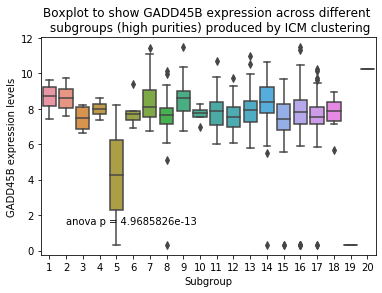

In [56]:
import scipy.stats as stats

# GADD45B levels across subgroups
bp = sns.boxplot(x="Subgroup", y="GADD45B", data=final_reddy[['GADD45B', 'Subgroup']])
bp.set_ylabel("GADD45B expression levels")
bp_title = "Boxplot to show GADD45B expression across different \n subgroups (high purities) produced by " + nmf_label + " clustering"
bp.set_title(bp_title)

# anova - parametric so each group's needs to be normally distributed for F-statistic to be reliable
reddy_subgroups = []
for sg_id in subgroups.keys():
    reddy_subgroups.append(final_reddy[final_reddy['Subgroup']==sg_id]['GADD45B'])

_, anova_p = stats.f_oneway(*reddy_subgroups)

# add anova p-value onto graph
plt.text(1, 1.5, "anova p = " + str(round(anova_p, 20)))

In [41]:
# read in signature data
nfkb_signatures = pd.read_excel('nfkb_signatures.xls')

In [42]:
### currently have to add number of subgroups in anova test

def plot_sig_boxplot(sig, sg):
    
    """
    This function produces a boxplot for a given NF-kB signature expression across our produced subgroups.
    
    Args:
        sig: string of NF-kB signature name.
        sg: full cohort.

    Returns:
        No return value.

    """
    
    # get lists of signature genes present and not present in expression data
    sig_existing = [gene for gene in nfkb_signatures[sig] if (gene in reddy_norm.columns)]

    # add existing genes to signature with 'Sample ID'
    sig_existing.append('Sample ID')
    final_sig = reddy_norm[sig_existing]
    
    # remove nan columns (happens because of different number of genes per signature)
    final_sig = final_sig.loc[:, final_sig.columns.notnull()]
    
    # remove duplicated columns
    final_sig = final_sig.loc[:,~final_sig.columns.duplicated()]
    
    # make sure same number of patients in signature and original data
    if len(final_sig) == len(reddy_norm):  
        
        # genes in final sig
        final_sig_genes = final_sig.drop(columns=['Sample ID']).columns
        
        # add median of signature to signature
        sig = final_sig
        sig['MedianOfSig'] = sig[final_sig_genes].median(axis=1)
        sig = sig.drop(columns=final_sig_genes)

        
        # join to subgroup
        sig = pd.merge(sig, sg[['Sample ID', 'Subgroup']], on='Sample ID', how='inner')
        
        bp = sns.boxplot(x="Subgroup", y="MedianOfSig", data=sig[['MedianOfSig', 'Subgroup']])
        bp.set_ylabel("NF-kB Signature Expression Levels")
        bp_title = "Boxplot to show NF-kB signature expression across \n different subgroups (all purities) produced by " + nmf_label + " clustering"
        bp.set_title(bp_title)
        
        sig_subgroups = []
        for sg_id in subgroups.keys():
            sig_subgroups.append(sig[sig['Subgroup']==sg_id]['MedianOfSig'])
        
        _, anova_p = stats.f_oneway(*sig_subgroups)
                   
        plt.text(1, -3, "anova p = " + str(round(anova_p, 10)))

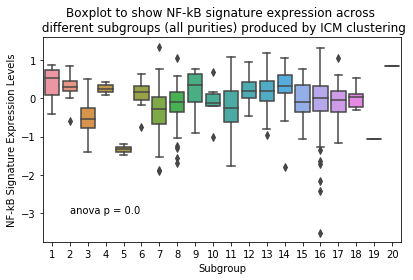

In [57]:
# signature boxplot

plot_sig_boxplot('ANNUNZIATA', final_reddy)
plt.tight_layout()
# plt.savefig('nmf-sig-bp-ap.png')

In [44]:
def create_and_plot_signature(sig, sg, sg_str, print_missing, axis):
    """
    Plots high and all purities signature correlation plots. 
    
    Args:
        sig: string of NF-kB signature name.
        sg: subgroup as dataframe.
        sg_str: subgroup name to include in graph title.
        print_missing: boolean to print missing values from signature.
        axis: axis to plot graph on.

    Returns:
        No return value.

    """

    # get lists of signature genes present in expression data
    sig_existing = [gene for gene in nfkb_signatures[sig] if (gene in reddy_norm.columns)]

    if print_missing:
        sig_missing = [gene for gene in nfkb_signatures[sig] if not (gene in reddy_norm.columns)]
        print("The Reddy expression data is missing the " + str(sig_missing) + 
              " genes used in the NF-kB " + sig + " signature.\n")

    # add existing genes to signature with 'Sample ID'
    sig_existing.append('Sample ID')
    final_sig = reddy_norm[sig_existing]
    
    # remove nan columns (happens because of different number of genes per signature)
    final_sig = final_sig.loc[:, final_sig.columns.notnull()]
    
    # remove duplicated columns
    final_sig = final_sig.loc[:,~final_sig.columns.duplicated()]
    
    # make sure same number of patients in signature and original data
    if len(final_sig) == len(reddy_norm):  
        
        # genes in final sig
        final_sig_genes = final_sig.drop(columns=['Sample ID']).columns
        
        # add median of signature to signature
        sig_gadd45b = final_sig
        sig_gadd45b['MedianOfSig'] = sig_gadd45b[final_sig_genes].median(axis=1)
        sig_gadd45b = sig_gadd45b.drop(columns=final_sig_genes)
        
        # join to COO cohort
        sig_gadd45b = pd.merge(sig_gadd45b, sg[['Sample ID']], on='Sample ID', how='inner')
        
        # now add gadd45b for scatter, original tumor purity for colour
        sig_gadd45b = pd.merge(sig_gadd45b, reddy_norm[['Sample ID', 'GADD45B']], on='Sample ID', how='inner')
        
        # setting up plot
        plot_title = "Correlation of GADD45B expression with the " + sig + " NF-kB \n target-gene signature in " + sg_str + " cohort"
        y_label = sig + " Signature"
                
        # y = NF-kB; x = GADD45B expression
        ax = sns.regplot(sig_gadd45b['GADD45B'], sig_gadd45b['MedianOfSig'], color='black', ax=axis)
        ax.set_title(plot_title)
        ax.set_xlabel("GADD45B Expression")
        ax.set_ylabel(y_label)
        
        # pearson correlation coefficient
        (r, p) = pearsonr(sig_gadd45b['GADD45B'], sig_gadd45b['MedianOfSig'])
        ax.annotate("r = {:.3f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes, fontsize=15)
        ax.annotate("p = {:.3e}".format(p),
                xy=(.1, .85), xycoords=ax.transAxes, fontsize=15)

    else:
        raise ValueError("Number of patients in signature is not equal to original number of patients.")
     
    # return final_sig


def plot_signature_purities(sig, high_pur_thresh):
    """
    Allows grid plot of all purity vs another purity dataset for all subgroups.

    Args:
        sig: string of NF-kB signature name.
        high_pur_thresh: threshold to use for high purities.
        
    Returns:
        No return value.

    """
    
    n = len(subgroups.keys())
    fig, axarr = plt.subplots(n, 2, figsize=(15,25))
    fig.tight_layout(w_pad=3, h_pad=5)
    for i, sg_id in enumerate(subgroups.keys()):
        
        sg = final_reddy[final_reddy['Subgroup']==sg_id]
        
        # high pur
        high_pur = sg[sg['TumorPurity'] > high_pur_thresh]
        high_name = "Subgroup " + str(sg_id) + " (high purities > " + str(high_pur_thresh*100) + "%) [n = " + str(len(high_pur)) + "]"
        create_and_plot_signature(sig, high_pur, high_name, False, axarr[i][0])

        # all pur
        all_name = "Subgroup " + str(sg_id) + " (all purities) [n = " + str(len(sg)) + "]"
        create_and_plot_signature(sig, sg, all_name, False, axarr[i][1])

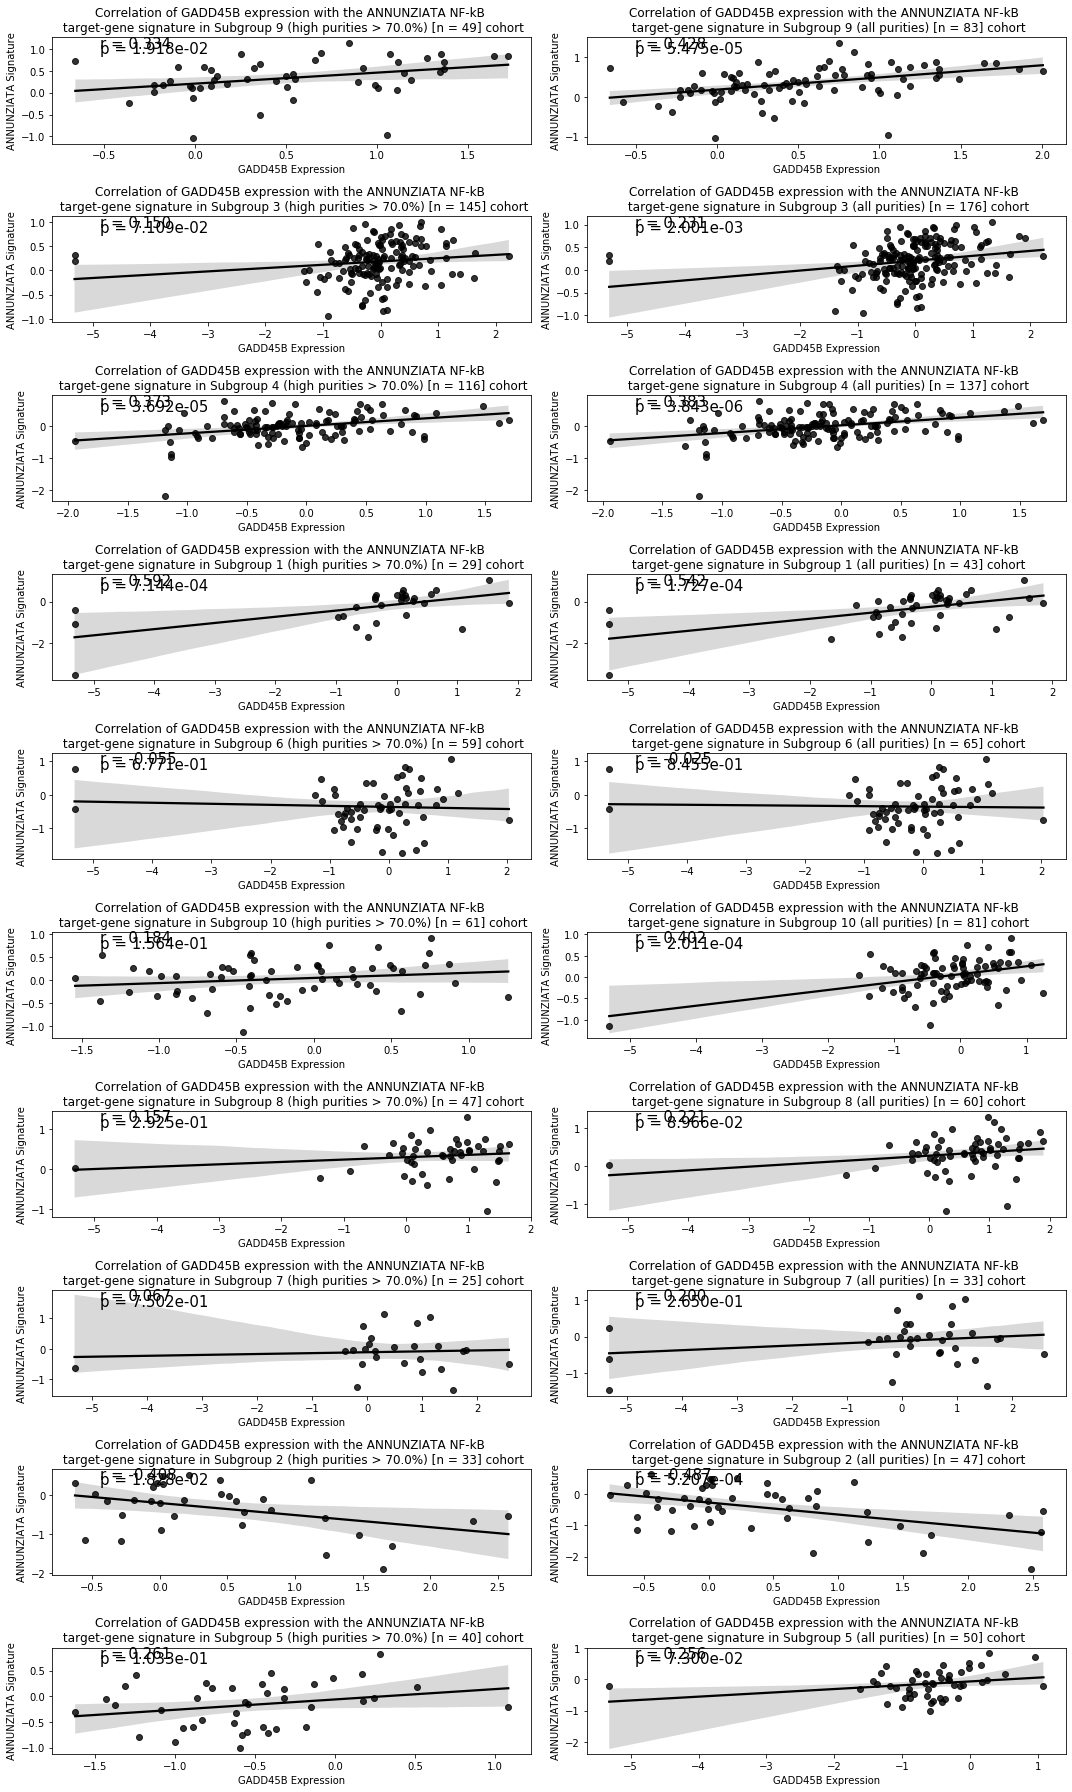

In [45]:
### sig correlation with gadd

# error here if only one patient in subgroup.
# should improve correlation test, doesn't accurately describe
# circular cluster of data

plot_signature_purities('ANNUNZIATA', high_pur_thresh=0.7)
plt.tight_layout()
# plt.savefig('nmf-sig.png')

0.14129978395372506


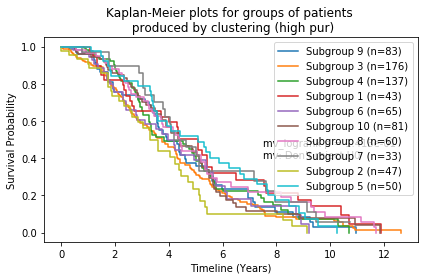

In [46]:
# UNIVARIATE SURVIVAL ANALYSIS
# the p values being significant act as a measure of whether the curves are different enough

from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

# for each cluster, now have a list of patient_ids
# use these patient_ids to get survival info for each cluster and plot
for cluster_id in subgroups.keys():
    sg = final_reddy[final_reddy['Sample ID'].isin(subgroups[cluster_id])]
    kmf.fit(sg['OverallSurvivalYears'], sg['Censored'])
    label = "Subgroup " + str(cluster_id) + " (n=" + str(len(sg)) +")"
    kmf.plot(ci_show=False, label=label)

# pairwise and multivariate logrank tests help us identify the differences between subgroups

from lifelines.statistics import multivariate_logrank_test, pairwise_logrank_test

# multivariate logrank checks if one is vastly different
# take the null distribution as chi-squared and then perform multivariate logrank test

mv_logrank = multivariate_logrank_test(event_durations=final_reddy['OverallSurvivalYears'], 
                                       event_observed=final_reddy['Censored'], 
                                       groups=final_reddy['Subgroup'])
mv_p_value = mv_logrank.p_value#round(mv_logrank.p_value, 12)
mv_decision = "mv: Don't reject H0" if (mv_p_value >= 0.05) else "mv: Can reject H0"
plt.text(7.5, 0.4, "mv_logrank p = " + '%.3e'%(mv_p_value) + "\n" + mv_decision)

# pairwise logrank tests differences between specific populations

pw_logrank = pairwise_logrank_test(event_durations=final_reddy['OverallSurvivalYears'], 
                                       event_observed=final_reddy['Censored'], 
                                       groups=final_reddy['Subgroup'])

pw_logrank.print_summary()
print(mv_p_value)

plt.title("Kaplan-Meier plots for groups of patients \n produced by clustering (high pur)")
plt.xlabel("Timeline (Years)")
plt.ylabel("Survival Probability")

plt.tight_layout()
# plt.savefig('icm-km-hp.png')

In [599]:
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

"""
MULTIVARIATE SURVIVAL ANALYSIS

CODE (not necessarily in order):
- Create Cox proportional hazards graphs for created subgroups at all and high purities

NOTES:
- N/A

RELEVANT DATA:
- N/A

"""

def coxph_subgroup_purity(cohort_data, cohort_name, high_pur_thresh):
    
    # create axes for plots
    fig, axarr = plt.subplots(2, 2, figsize=(12,12))
    fig.tight_layout(w_pad=3, h_pad=3.5)
    
    cohort = cohort_data[["OverallSurvivalYears", "Censored", "TumorPurity", "IPI",
                         "AgeAtDiagnosis", "ResponseToInitialTherapy", "GADD45B", "GRM"]]
    
    ### all purities

    cohort_all_pur = cohort.drop(['TumorPurity'], axis=1)
    n_all = len(cohort_all_pur)
    
    # need to add proper penalty to mimic elastic net
    cph_all_pur = CoxPHFitter(penalizer=0.05)
    cph_all_pur.fit(cohort_all_pur, duration_col='OverallSurvivalYears', event_col='Censored')
    #cph_all_pur.print_summary()
    
    # plot graph # need to add x and y
    plot_title = "Cox PH for " + cohort_name + " with all purities [n = " + str(n_all) + "] \n varying GADD45B expression" 
    
    # Check assumptions for full cohort and plot hazard ratios
    cph_all_pur.check_assumptions(cohort_all_pur, p_value_threshold=0.005, show_plots=False)
    cph_all_pur.plot(ax=axarr[0][0])
    
    cph_all_pur.plot_covariate_groups('GADD45B', [0, 2, 4, 6, 8, 10, 12], cmap='coolwarm', title=plot_title,
                                     ax=axarr[0][1])
    
    ### high purity
    cohort_high_pur = cohort[cohort['TumorPurity'] > high_pur_thresh]
    cohort_high_pur = cohort_high_pur.drop(['TumorPurity'], axis=1)
    n_high = len(cohort_high_pur)
    
    # need to add proper penalty to mimic elastic net
    cph_high_pur = CoxPHFitter(penalizer=0.05)
    cph_high_pur.fit(cohort_high_pur, duration_col='OverallSurvivalYears', event_col='Censored')
    #cph_high_pur.print_summary()
    
    # plot graph # need to add x and y
    plot_title = "Cox PH for " + cohort_name + " with high purities  (>" + str(high_pur_thresh*100) + "%)  [n = " + str(n_high) + "] \n varying GADD45B expression" 
    
    # Check assumptions for high purity cohort and plot hazard ratios
    cph_high_pur.check_assumptions(cohort_high_pur, p_value_threshold=0.005, show_plots=False)
    cph_high_pur.plot(ax=axarr[1][0])
    
    cph_high_pur.plot_covariate_groups('GADD45B', [0, 2, 4, 6, 8, 10, 12], cmap='coolwarm', title=plot_title,
                                     ax=axarr[1][1])
    
    return cph_all_pur, cph_high_pur
    

In [600]:
print("There are " + str(len(subgroups.keys())) +  " subgroups to compare.")

There are 6 subgroups to compare.


Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.


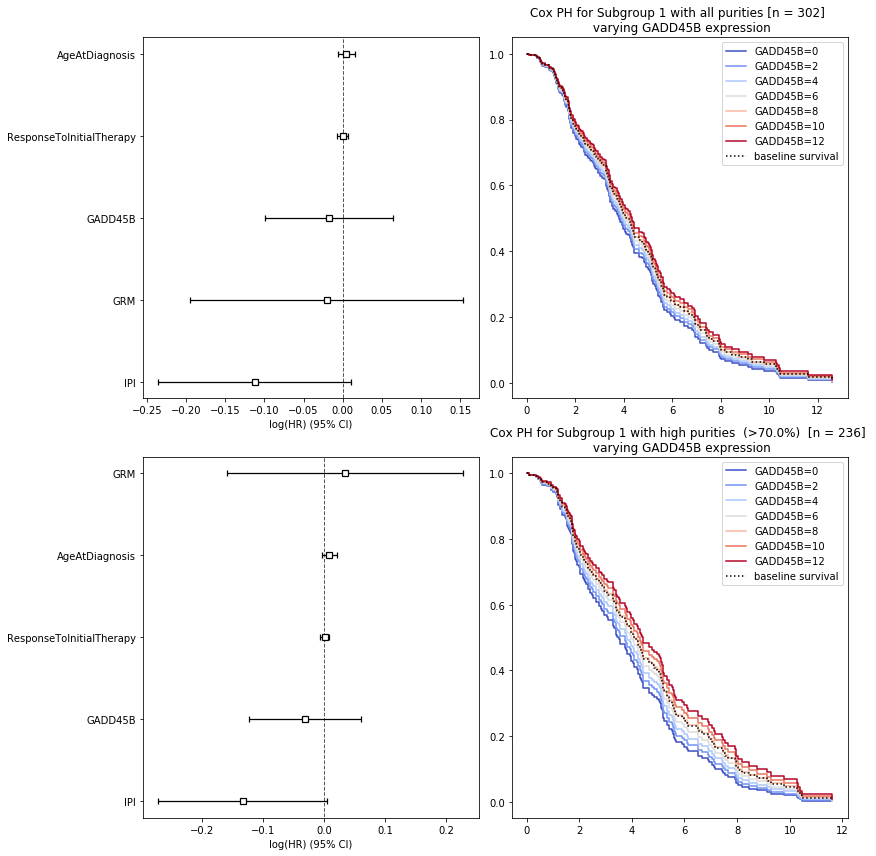

In [601]:
# can do this for each subgroup

coxph_subgroup_purity(final_reddy[final_reddy['Subgroup'] == 1], "Subgroup 1", 0.7)
plt.tight_layout()
plt.savefig('icm-cox-sg1.png')

In [47]:
final_reddy.to_csv('10-G-B.csv')

In [ ]:
### SUBGROUP EVALUATION

In [124]:
# if using subgroups that you've just created
gs_clinical = final_reddy.iloc[:,:].copy()

# can use to read in my final subgroups that have attached in folder
# gs_clinical = pd.read_csv('[...].csv')

In [156]:
# do this for each subgroup - check the number you have
sg1 = gs_clinical[gs_clinical['Subgroup']==1]
sg2 = gs_clinical[gs_clinical['Subgroup']==2]
sg3 = gs_clinical[gs_clinical['Subgroup']==3]
sg4 = gs_clinical[gs_clinical['Subgroup']==4]

In [158]:
### FIND BEST RANK FOR SUBGROUP

# get 1500 genes for patients in SG1

sg_ids = sg1.index.to_numpy()
sg_filtered = filtered_reddy.iloc[sg_ids,:].copy()

# find best rank
rank_cands = range(3,16,3)
reddy_subset = sg_filtered.iloc[:,:].copy()
reddy_to_cluster = reddy_subset.to_numpy()
reddy_to_cluster = preprocessing.Normalizer().fit_transform(reddy_to_cluster)

# patients
sg_patients = reddy_subset.index.values
# genes
sg_genes = reddy_subset.columns.values

bd_gene = nimfa.Bd(reddy_to_cluster.T, seed="random_c", theta=0.1)
summary = bd_gene.estimate_rank(rank_range=rank_cands, n_run=30, what='all')

summary[15].keys()

dict_keys(['rank', 'sparseness', 'rss', 'evar', 'residuals', 'connectivity', 'predict_samples', 'predict_features', 'score_features', 'select_features', 'dispersion', 'cophenetic', 'consensus', 'euclidean', 'kl', 'n_iter', 'n_run'])

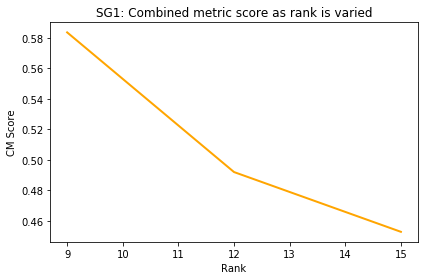

In [160]:
rss = [summary[rank]['rss'] for rank in rank_cands]
coph = [summary[rank]['cophenetic'] for rank in rank_cands]
disp = [summary[rank]['dispersion'] for rank in rank_cands]

# subgroup label
nmf_label = "SG1"

max_rss = max(rss)
new_rss = [i/max_rss for i in rss]
new_rss
#
rank = rank_cands
max_rank = 10
new_rank =[i/max_rank for i in rank]
new_rank
#
rank_metrics = list(zip(rank, coph, disp, new_rss, new_rank))
rank_metrics
#
# create new residuals
# create new ranks in same way
# want to have s=bbigger groups so easier to give treatment and not too indivudal, generliase better
def combined_metric(cci, d, rss, rank):
    return (0.5*cci + 0.5*d - 0.1*rss - 0.1*(rank))

final_scores = []
for rank in rank_metrics:
    cm = combined_metric(rank[1], rank[2], rank[3], rank[4])
    final_scores.append((rank[0], cm))
#
#plt.plot(rank_cands, rss, 'og-', label='RSS', linewidth=2
plt.plot(*zip(*final_scores), 'orange',linewidth=2)
cm_title = nmf_label + ": Combined metric score as rank is varied"
plt.title(cm_title)
plt.ylabel("CM Score")
plt.xlabel("Rank")
plt.tight_layout()

In [255]:
# pick best rank based on CM score
rank = max(final_scores, key=lambda x: x[1])[0]

# rerun clustering on patient subgroup at best rank
# gene clustering also works but select_features would take patients
# note that we run a sufficient number of times

sg_bd = nimfa.Bd(reddy_to_cluster.T, rank=rank, seed="random_c", theta=0.1,
                   track_factor=True, n_run=40)
sg_bd_fit = sg_bd()

In [247]:
W = sg_bd_fit.fit.basis()

def get_top_genes(c, k, col, plot):
    """
    Return top k genes for the c-th column of the basis. Optional boolean for plotting
    horizontal bar chart with weights of components.
    
    Args:
        c: Column index. There are |rank| columns.
        k: Number of genes to be returned for the c-th column.
        col: Colour of bars in plot.
        plot: Boolean set to True if bar plot desired.
    
    Returns:
        labels: List of k genes most associated with basis column.
    
    """

    # flatten c-th basis column, then sort, then return k top components
    topk = np.argsort(np.asarray(W[:,c]).flatten())[-k:]
    
    # val gets these main components from the column
    val = W[topk, c]
    val2 = np.ravel(val)

    # re-add patient labels to these, then add names
    labels = [sg_genes[idx] for idx in topk]

    # plot graph
    if plot:
        plt.barh(np.arange(k), val2, align="center", color=col)
        plt.yticks(np.arange(k), labels)
        plt.xlabel("Weight")
        plt.ylabel("Gene")

    return labels

# plt.savefig('col5.png')`

In [248]:
from lifelines import CoxPHFitter
from pylab import rcParams

# set figure size
rcParams['figure.figsize'] = 5, 4

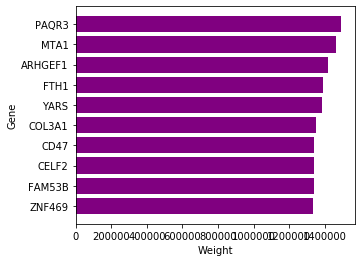

In [254]:
# test function works
sg1_col0 = get_top_genes(0, 10, 'purple', True)

In [249]:
# add all the top genes from each cluster (process)
num_genes = 3

sg_process_genes = []
for r in range(rank):
    sg_col = get_top_genes(r, num_genes, 'r', False)
    # print(sg_col)
    for i in sg_col:
        sg_process_genes.append(i)
        
# check for overlap between subgroups
# [i for i in sg1_process_genes if i in gene_set]
        
# find best genes using gene score
bools_test = sg_bd_fit.fit.select_features()
ids_test = np.argwhere(bools_test==True).flatten()
gi_genes = [sg_genes[idx] for idx in np.nonzero(ids_test)[0]]

# add genes not in scored genes but in process genes
for gene in sg_process_genes:
    gi_genes.append(gene)
    
# print list of genes
#print('\n'.join(gi_genes))

In [285]:
# want to find the 10 genes that are most prognostic of death
# plot a coxph of all relevant genes i.e. genes that contribute to each cluster heavily and/or contribute
# to all clusters sufficiently

"""
k-fold was working, not sure why it's acting strange -> need to look at again.
could maybe try sksurv coxnet again since has full scope - but plotting issues

from lifelines.utils import k_fold_cross_validation

cph = CoxPHFitter(penalizer=0.01)
scores = k_fold_cross_validation(cph, sg_final, 'OverallSurvivalYears', event_col='Censored', k=10)
print(scores)
"""


def most_prognostic_genes(sg, initial_gene_index, col):
    """
    Plots hazard ratios from Cox model of 10 (or less) of the most "important" genes in terms of their
    impact on components of the basis.
    
    Args:
        sg: Patient subgroup.
        initial_gene_index: list of genes to be used.
        col: colour of eventual hazard ratios plot plot.
        
    Returns:
        Final 10 genes
    """
    
    if 'Sample ID' not in initial_gene_index:
        initial_gene_index.append('Sample ID')
    
    inital_cph = create_subgroup_coxph(sg, initial_gene_index)
    
    # find top 10 genes that are bad for survival
    summ = inital_cph.summary
    summ = summ.sort_values(by=['coef'], ascending=False)
    main_genes = summ.head(10).index.values
    
    if 'Sample ID' not in main_genes:
        main_genes = np.append(main_genes, 'Sample ID')

    final_gene_index = main_genes
    
    # get cox of main genes *relative* to each other
    final_cph = create_subgroup_coxph(sg, final_gene_index)

    # plot coxph of top 10 genes
    final_cph.plot(color=col)
    plt.tight_layout()
    
    return main_genes

    
### ADD CROSS-VALIDATION    
def create_subgroup_coxph(sg, gene_index):
    
    sg_reddy = pd.merge(reddy, sg['Sample ID'], on='Sample ID', how='inner')

    # change topk k value so can take all
    sg_reddy = sg_reddy[gene_index]
    sg_clinical = sg[["OverallSurvivalYears", "Censored", "Sample ID"]]

    sg_final = pd.merge(sg_reddy, sg_clinical, on='Sample ID', how='inner')
    sg_final = sg_final.drop(['Sample ID'], axis=1)

    # alpha sets error bars
    # note: error bars determine x-axis so set bigger if want smaller x range
    cph_sg = CoxPHFitter(penalizer=0.05, alpha=0.999)
    cph_sg.fit(sg_final, duration_col='OverallSurvivalYears', event_col='Censored')
    
    return cph_sg
    

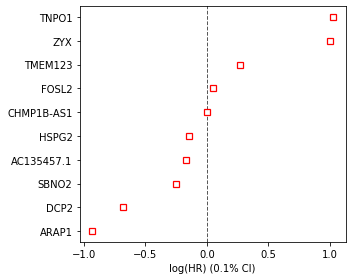

In [286]:
main_g = most_prognostic_genes(sg4, reddy_gene_index, 'r')